In [1]:
# -----------------------------
# 1. LIBRARIES & CONFIG
# -----------------------------
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import wandb

# wandb
wandb.init(project="polygon-colorizer", config={
    "epochs": 100,
    "batch_size": 16,
    "lr": 1e-3,
    "embedding_dim": 16,
    "loss_fn": "L1Loss",
    "img_size": 128
})

config = wandb.config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 010sachinmishra (010sachinmishra-international-institute-of-information-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


In [5]:
%cd /content/drive/MyDrive/AYNA Project/dataset

/content/drive/MyDrive/AYNA Project/dataset


In [6]:
import os

print("Train input exists:", os.path.exists('./training/inputs'))
print("Train output exists:", os.path.exists('./training/outputs'))
print("Train JSON exists:", os.path.isfile('./training/data.json'))
print("Val input exists:", os.path.exists('./validation/inputs'))
print("Val output exists:", os.path.exists('./validation/outputs'))
print("Val JSON exists:", os.path.isfile('./validation/data.json'))

Train input exists: True
Train output exists: True
Train JSON exists: True
Val input exists: True
Val output exists: True
Val JSON exists: True


In [9]:
# -----------------------------
# 2. COLOR MAPPING + TRANSFORMS
# -----------------------------
with open('./training/data.json', 'r') as f:
    data = json.load(f)

color_list = sorted(set(item['colour'] for item in data))
color2idx = {color: idx for idx, color in enumerate(color_list)}
idx2color = {idx: color for color, idx in color2idx.items()}

transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor()
])

In [11]:
# -----------------------------
# 3. DATASET CLASS
# -----------------------------
class PolygonColorDataset(Dataset):
    def __init__(self, input_dir, output_dir, json_path, color2idx, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.color2idx = color2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.input_dir, item['input_polygon'])
        output_path = os.path.join(self.output_dir, item['output_image'])
        color_idx = self.color2idx[item['colour']]

        input_img = Image.open(input_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')
        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)
        return input_img, torch.tensor(color_idx), output_img

In [12]:
# -----------------------------
# 4. UNet CONDITIONAL MODEL
# -----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class UNetConditional(nn.Module):
    def __init__(self, num_colors, emb_dim=16):
        super().__init__()
        self.color_emb = nn.Embedding(num_colors, emb_dim)
        self.inc = DoubleConv(3 + emb_dim, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x, color_idx):
        b, _, h, w = x.shape
        emb = self.color_emb(color_idx).view(b, -1, 1, 1).expand(-1, -1, h, w)
        x = torch.cat([x, emb], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv3(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv1(x)
        return torch.sigmoid(self.outc(x))




In [13]:
# -----------------------------
# 5. TRAINING + VALIDATION
# -----------------------------
train_dataset = PolygonColorDataset('./training/inputs', './training/outputs', './training/data.json', color2idx, transform)
val_dataset = PolygonColorDataset('./validation/inputs', './validation/outputs', './validation/data.json', color2idx, transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size)

model = UNetConditional(num_colors=len(color2idx), emb_dim=config.embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = nn.L1Loss()

for epoch in range(config.epochs):
    model.train()
    train_loss = 0
    for x, color_idx, y in train_loader:
        x, y, color_idx = x.to(device), y.to(device), color_idx.to(device)
        optimizer.zero_grad()
        pred = model(x, color_idx)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, color_idx, y in val_loader:
            x, y, color_idx = x.to(device), y.to(device), color_idx.to(device)
            pred = model(x, color_idx)
            val_loss += criterion(pred, y).item()

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss / len(train_loader),
        "val_loss": val_loss / len(val_loader)
    })
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1 | Train Loss: 0.4734 | Val Loss: 0.4974
Epoch 2 | Train Loss: 0.4239 | Val Loss: 0.5135
Epoch 3 | Train Loss: 0.3992 | Val Loss: 0.5020
Epoch 4 | Train Loss: 0.3755 | Val Loss: 0.4601
Epoch 5 | Train Loss: 0.3562 | Val Loss: 0.4523
Epoch 6 | Train Loss: 0.3390 | Val Loss: 0.3685
Epoch 7 | Train Loss: 0.3174 | Val Loss: 0.3538
Epoch 8 | Train Loss: 0.3008 | Val Loss: 0.3323
Epoch 9 | Train Loss: 0.2927 | Val Loss: 0.3069
Epoch 10 | Train Loss: 0.2798 | Val Loss: 0.3155
Epoch 11 | Train Loss: 0.2653 | Val Loss: 0.3090
Epoch 12 | Train Loss: 0.2433 | Val Loss: 0.2773
Epoch 13 | Train Loss: 0.2365 | Val Loss: 0.2508
Epoch 14 | Train Loss: 0.2236 | Val Loss: 0.2428
Epoch 15 | Train Loss: 0.2160 | Val Loss: 0.2232
Epoch 16 | Train Loss: 0.1986 | Val Loss: 0.2498
Epoch 17 | Train Loss: 0.1902 | Val Loss: 0.2294
Epoch 18 | Train Loss: 0.1785 | Val Loss: 0.2058
Epoch 19 | Train Loss: 0.1691 | Val Loss: 0.1773
Epoch 20 | Train Loss: 0.1645 | Val Loss: 0.1498
Epoch 21 | Train Loss: 0.1567

In [14]:
# Save the model
torch.save(model.state_dict(), "unet_polygon_color.pth")

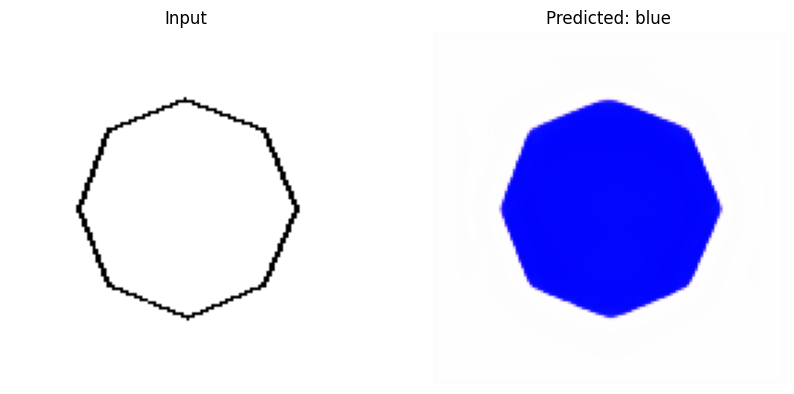

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01739
val_loss,0.00483


In [15]:
# -----------------------------
# 6. INFERENCE
# -----------------------------
model.eval()
test_img_path = './validation/inputs/octagon.png'
test_color = 'blue'

input_img = Image.open(test_img_path).convert('RGB')
input_tensor = transform(input_img).unsqueeze(0).to(device)
color_idx_tensor = torch.tensor([color2idx[test_color]]).to(device)

with torch.no_grad():
    pred = model(input_tensor, color_idx_tensor)
    output_img = pred.squeeze(0).cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(input_img); plt.axis('off')
plt.subplot(1,2,2)
plt.title(f"Predicted: {test_color}")
plt.imshow(output_img); plt.axis('off')
plt.show()

wandb.finish()